In [5]:
# Generelle moduler og funksjonsbeskrivelser brukt i forelesningen
from numpy import sin, cos, pi, exp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [8.00, 4.5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.xmargin"] = 0.0

def displayFrequencyResponse(b, a=[1], num=None, mag='log', new_figure=True, **kwargs):
    w, Hw = sig.freqz(b, a)
    H_amp = np.abs(Hw)
    H_phase = np.unwrap(np.angle(Hw, deg=True), period=360)
    if new_figure==True:
        if num is not None:
            plt.close(num)
        fig, [ax1, ax2] = plt.subplots(num=num, nrows=2)
    else :
        fig = plt.figure(num=num)
        ax1 = fig.axes[0]
        ax2 = fig.axes[1]
    
    if mag.lower()=='log':
        ax1.plot(w, 20*np.log10(H_amp), **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$ (dB)')
    else:
        ax1.plot(w, H_amp, **kwargs)
        ax1.set_ylabel(r'$\left| H\left(\hat{\omega}\right)\right|$')

    ax1.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax1.set_xlabel(r'Digital Frekvens $\hat{\omega}$')

    ax1.set_xlim([0, pi])
    ax1.set_title(r'Frekvensrespons $H\left(\hat{\omega}\right)$')

    phaseResp, = ax2.plot(w, H_phase, **kwargs)

    ax2.set_xticks(np.linspace(0, 1, 6)*pi, [str(round(i,2))+r'$\pi$' for i in np.linspace(0, 1, 6)])
    ax2.set_xlabel(r'Digital Frekvens $\hat{\omega}$')
    ax2.set_ylabel(r'$\angle H\left(\hat{\omega}\right)$ (degrees)')

    if "label" in kwargs.keys():
        ax2.legend()
        ax1.legend()
    fig.tight_layout(pad=0.1, w_pad=1.0, h_pad=1.0)

%matplotlib ipympl

<img src="figures/NTNU_logo_vertical.svg" align="left" style="width: 30%">
<br clear="all" />
<br></br>

# Lowpass FIR Filter Design

* **Emne AIS2201 - Signalbehandling**
* **Uke 43, 2025**
* **Relevant Pensum:**
    * Kapittel 5.3 - 5.6 i læreboka Understanding Digital Signal Processing
* **Underviser: Kai Erik Hoff**

# Topics

* Evaluating digital FIR filters
* Design of FIR lowpass filters using the Window method

### Learning goals

* Ability to formulate target filter specifications given
* How to design a digital FIR filter to a particular set of specifications

# Spectral analysis vs. filter design
<div style="width: 100%;">
    <div style="width: 45%; float: left">
    <br>
    <h3> Spectral analysis </h3>
    <ol>
        <li>Time-domain signal samples $x[n]$ are known.</li>
        <li>Frequency content to <i>not</i> known initially.</li>
        <li>Goal is to estimate/approximate the frequency composition of $x[n]$.</li>
    </ol>  
    </div>
    <div style="width: 45%; float: right">
    <br>
    <h3> Filter design </h3>
    <ol>
        <li>Desired frequency composition $H_{\text{ideal}}(\hat{\omega})$.</li>
        <li>Time-domain samples <i>h[n]</i> for the impuolse response is <i>not</i> known.</li>
        <li>Goal is to identify an impulse response (<i>h[n]</i>) which comes as close as possible to the desired frequency content $H_{\text{ideal}}(\hat{\omega})$.</li>
    </ol> 
    </div>
</div> 

* Think of FIR filter design as "spectral analysis in reverse".

# The Ideal Lowpass Filter


* An ideal filter has a "brick wall" frequency response
    * Passband gain $ = 1$
    * Stopband attenuation $= \infty$
    * Infinitely steep cutoff


* Ideal two-sided response for a lowpass filter shown below:

<div style="width: 100%;">
    <img src="figures/H_lowpass_ideal.svg" style="width: 50%; float: right" />
    <div style="width: 40%; float: left">
    <br>
    <p>$$H_{\text{ideal}}(\hat{\omega}) = \begin{cases}1, & |\hat{\omega}| \leq \hat{\omega}_c \\ 0, & |\hat{\omega}| > \hat{\omega}_c \end{cases} $$</p>
    </div>
</div> 


# Important discrete-time fourier transform (DTFT) pairs

<img src="figures/Slide1.PNG" style="width: 90%; margin-left: 50px" />

# The $\text{sinc}(x)$ function:

* Defiinition:
$$\text{sinc}(x) = \frac{\sin(\pi\cdot x)}{\pi\cdot x}$$
    * Evaluated for the limit  $x\rightarrow 0$:
    $$\lim_{x\rightarrow 0} \frac{\sin(\pi\cdot x)}{\pi\cdot x} = \frac{0}{0} = 1$$
    

* Accessible in python through the `numpy`-module as [`numpy.sinc()`](https://numpy.org/doc/stable/reference/generated/numpy.sinc.html).

# Ideal impulse response

<div style="width: 100%;">
    <img src="figures/hw_lowpass_ideal.svg" style="width: 45%; float: right" />
    <div style="width: 45%; float: left">
    <br>
    <ul>
        <li>Given an ideal frequency response:
        </ul>
    <p>$$H_{\text{ideal}}(\hat{\omega}) = \begin{cases}1, & |\hat{\omega}| \leq \hat{\omega}_c \\ 0, & |\hat{\omega}| > \hat{\omega}_c \end{cases} $$</p>
    </div>
</div> 

<div style="width: 100%;">
    <img src="figures/hn_lowpass_ideal.svg" style="width: 45%; float: right" />
    <div style="width: 45%; float: left">
    <br>
    <ul>
        <li>The Inverse Discrete-Time Fourier Transform (IDTFT) can be used to calculate the ideal impulse response:
        </ul>
    <p>$$\text{IDTFT}\left(H_{\text{ideal}}(\hat{\omega})\right) = \frac{\sin(\hat{\omega}_c\cdot n)}{\pi\cdot n} = h_{\text{ideal}}[n]$$</p>
    </div>
</div> 

# Realizable filters

* There are two main problems with the impulse response $h_{\text{ideal}}[n]$ as calculated in the previous slide.
    1. The impulse response has infinite length, implying an infinite number of taps $M$
    2. The filter is not causal ($h_{\text{ideal}}[n] \neq 0, n < 0$)

* To address problem 1, we can truncate the impulse response:
$$h_{\text{w}}[n] = \begin{cases} h_{\text{ideal}}[n], & |n| \leq \frac{M-1}{2} \\ 0, & |n| > \frac{M-1}{2}\end{cases}$$
    * $h_{\text{w}}[n]$ is now symmetric about $n=0$, and has a total length of $M$ samples (assumes $M$ is odd).

* To address problem 2, we can shift the impulse response $h_{\text{w}}[n]$ by $\frac{M-1}{2}$ samples.
$$h_{\text{LP}}[n] = h_{\text{w}}\left[n - \frac{M-1}{2} \right]$$
    * This ensures causality: $h_{\text{LP}}[n] = 0, \ n < 0$

## Code example: 

* Find the impulse respone $h[n]$ for a $M=37$-tap lowpass FIR filter with edge frequency $\hat{\omega}_c = 0.4\pi$ radians per sample.
    * Important note: 
$$\frac{\sin(\hat{\omega}_0\cdot n)}{\pi \cdot n} = \frac{\hat{\omega}_0}{\pi}\cdot \text{sinc}\left(\frac{\hat{\omega}_0}{\pi}\cdot n \right)$$

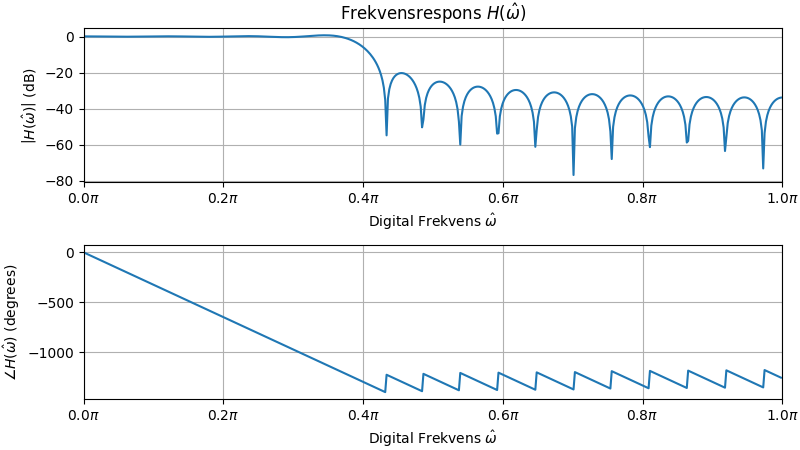

In [26]:
M = 37  # Number of filter taps
n = np.arange(M)

w_c = 0.4*pi

hn = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2))
displayFrequencyResponse(hn, num=1)


### Evaluation:
* Filter has *roughly* the desired shape
* Passband lasts up to $\hat{\omega} \approx 0.4\pi$ 
* Filter gain declines rapidly for $\hat{\omega} < 0.4\pi$

* Open question:
> Can we improve our filter, and what exactly would constitute an improvement on filter properties?

# Important terms in filter design


<div style="width: 100%;">
<img src="figures/Fig1_FilterParams.png" style="width: 60%; float: left" />
    <div style="width: 30%; float: right; margin-left: -10%">
    <ul>
        <br>
        <li><b>Minimum Stopband Attenuation:</b><br>the distance between the passband and the <i>hightest point</i> in the stopband.</li>
        <li><b>Stopband:</b><br>The frequency band where filter attenuation is greater than the minimum stopband attenuation. Bounded by $\hat{\omega}_{\text{stop}}$</li>
        <li><b>Maximum Passband Ripple:</b><br>Peak permissable fluctuations within the passband.</li>
        <li><b>Passbånd:</b><br>frequency band where filter gain is within the limits set by max passband ripple. Bounded by $\hat{\omega}_{\text{pass}}$</li>
        <li><b>Transition width ($\text{TW}$):</b><br> Width of frequency band between edge of passband and edge of stopband.</li>
    </ul> 
    </div>
</div> 


# Example filter properties:

<div style="width: 100%;">
    <img src="figures/filter_properties.svg" style="width: 50%; float: right" />
    <div style="width: 40%; float: left">
    <br>
    <ul>
        <li>The minimum stopband attenuation is $21 \text{dB}$, roughly equivalent to reducing magnitude by a factor of $11$ in linear scale.</li>
        <li>The transition width is approximately $\text{TW} \approx \frac{\pi}{20} \text{ rad}/\text{sample}$</li>
    </ul>
    </div>
</div> 



* "Improving" the filter could translate to:
    1. Reducing transition width ($\text{TW}$)
    2. Increasing minimum stopband attenuation

# Filter length and transition width
<img src="figures/Slide6.PNG" style="width: 80%; margin-left: 50px" />

* In order to improve transition width, all we need to do is increase number of filter taps.

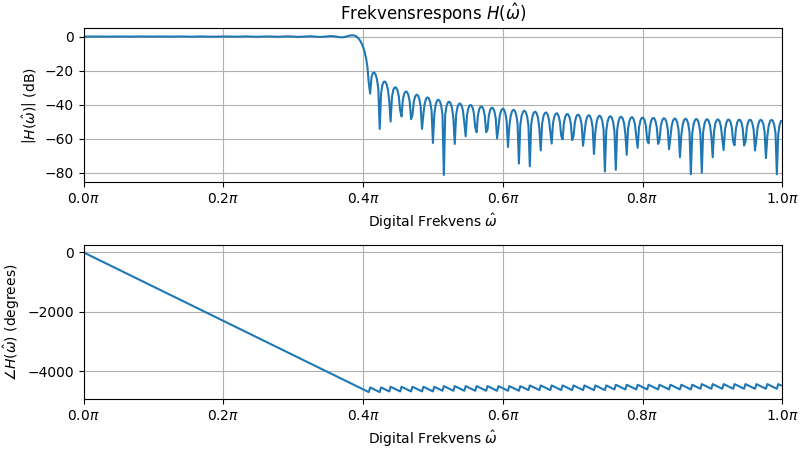

In [25]:
M = 129  # Number of filter taps
n = np.arange(M)

w_c = 0.4*pi

hn = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2))
displayFrequencyResponse(hn, num=2)


# Design process described in the *frequency domain*

* In order to improve our filter's stopband attenuation, we need to understand how our design process affect the frequency-domain properties of the filter.

1. Truncation equals windowing.
    * Translates to *convolution* in the frequency domain

\begin{align*}
h_{\text{w}}[n] &= \begin{cases} h_{\text{ideal}}[n], & |n| \leq \frac{M-1}{2} \\ 0, & |n| > \frac{M-1}{2}\end{cases} & & & H_{\text{w}}(\hat{\omega}) &= \left( H_I(\hat{\omega}) * W_r(\hat{\omega}) \right) \\ 
&= h_{\text{ideal}}[n] \cdot w_{\text{r}}[n] & \stackrel{\mathrm{DTFT}}{\longleftrightarrow} & & &\\
& \text{where} & & & & \text{where } \\
w_{\text{r}}[n] & = \begin{cases} 1, & |n| \leq \frac{M-1}{2} \\ 0, & |n| > \frac{M-1}{2}\end{cases} & & & W_r(\hat{\omega}) &= \frac{\sin\left(\hat{\omega}(M)/2\right)}{\sin(\hat{\omega}/2)}\\
\end{align*}

2. Time shift equals *rotation* in the frequency domain:

\begin{align*}
h_{\text{LP}}[n] &= h_{\text{w}}\left[n - \frac{M-1}{2} \right] & \stackrel{\mathrm{DTFT}}{\longleftrightarrow} & & H_{LP}(\hat{\omega}) &= e^{-j\hat{\omega} \cdot \frac{M-1}{2}} \cdot H_{\text{w}}(\hat{\omega}) 
\end{align*}

## Windowing in the frequency domain - graphical illustration
<img src="figures/Slide5.PNG" style="width: 90%; margin-left: 50px" />

## Time shift in the frequency domain - graphical illustration

# Improving filter properties through windowing

* Filter design method so far uses *rectangular windows*


* As with spectral analysis, we can get better results by using a more suitable window function.
    * We could say we have *spectral leakage* of the ideal passband into the stopband. Our job is to minimize this leakage.

# Suggested window: *Hamming*

* Expression: 
$$w[n] = 0.54 - 0.46 \cdot \cos\left(\frac{2\pi \cdot n}{M}\right)$$
<img src="figures/Slide9.PNG" style="width: 60%; margin-left: 50px" />

# Frequency response of filter with hamming window

<img src="figures/Slide10.PNG" style="width: 90%; margin-left: 50px" />

## Code example:
* Use a window function to improve our filter's stopband attenuation.

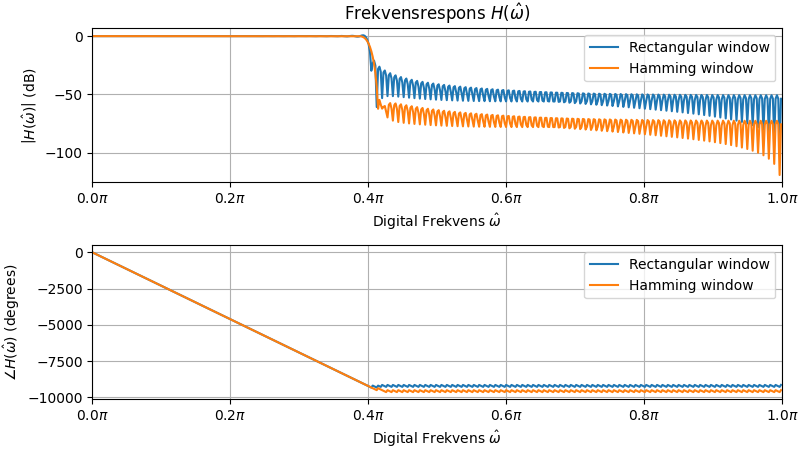

In [23]:
M = 257

n = np.arange(M)
w_c = 0.4*pi

hn_rect = w_c/pi*np.sinc(w_c/pi*(n-(M-1)/2))
hn_hamming = hn_rect * sig.windows.hamming(M)

displayFrequencyResponse(hn_rect, num=3, label="Rectangular window")
displayFrequencyResponse(hn_hamming, num=3, label="Hamming window", new_figure=False)

# Window lowpass design method summarized
<img src="figures/Slide11.PNG" style="width: 90%; margin-left: 50px" />

# Window design method in the frequency domain
<img src="figures/Slide12.PNG" style="width: 90%; margin-left: 50px" />

# Final points:




* $-6\text{dB}$ corner frequency $\hat{\omega}_{\text{c}}$ used in the design equation will be in the *middle* of the transition band.
    * $\hat{\omega}_{\text{pass}} = \hat{\omega}_{\text{c}} - \frac{\text{TW}}{2}$
    * $\hat{\omega}_{\text{stop}} = \hat{\omega}_{\text{c}} + \frac{\text{TW}}{2}$

#### Notes:
Many of you may be used to the cutoff frequency being defined as the $-3\text{dB}$ crossover point. However, this definition is only really valid for analog butterworth filters where cutoff frequency $\omega_c$ has a clear connection to $s$-plane pole placement. A more universal definition for lowpass filters would be that the cutoff frequency is found "where the passband ends", allowing for differing filter types to have different definitions of what constitues a passband. 

For practical FIR filers, the passband is defined as the region where filter gain remains within the limits set by maximum passband ripple. The cutoff frequency for such a filter usually refers to $\hat{\omega}_{\text{pass}}$.

* Estimating filter order/transition width:<br>
$$\hat{M} = \frac{\text{Minimum Stopband Attenuation}}{22(\hat{f}_{\text{stop}} - \hat{f}_{\text{pass}})}, \ \ \ \hat{f} = \frac{\hat{\omega}}{2\pi} \tag{5.49}$$

#### Notes:
$\hat{M}$ is an *estimate* of how many taps the filter would need to achieve the specified stopband attenuation and transition width. To be sure, it is always prudent to use filter analysis to verify the filter has the desired properties.

# Any questions?